# Variational Autoencoder v PCA

In this notebook I want to show two types of dimensionality reduction for tabular data: PCA and Autoencoders.

I use the [wine dataset](https://archive.ics.uci.edu/ml/datasets/wine) to show how Variational Autoencoder (VAE) with PyTorch on tabular data works and compare it to the classic PCA approach. I use the PCA/VAE to reduce the dimensionality of dataset, in this case don to 3 Variables (embeddings). I then plot the embeddings in a 3D graph to show how VAE is similar to a PCA but works in a non-linear way. 

## TODO

* safe model
* safe latent space

# Imports

In [1]:
# mamba create -n sdiv_spectra python=3.10
# mamba init
# mamba activate sdiv_spectra
# mamba install pytorch matplotlib scikit-learn pandas -c conda-forge

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable
from sklearn.decomposition import PCA

import pandas as pd
import numpy as np
from sklearn import preprocessing

import matplotlib.pyplot as plt
import os
import csv

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Define Path to Dataset

In [3]:
# path to dataset
data_path = '/mnt/gsdata/users/kattenborn/data/sdiv_spectra/canopy_data/DB_47_Meta_EC.csv'
#data_path = 'G:/My Drive/projects/project_sPectra/DB_47_Meta_EC.csv'

# path for model output
model_out_dir = '/mnt/gsdata/users/kattenborn/data/sdiv_spectra/dimred_canopy_v3/'
# check if model output directory exists and create it if not
if not os.path.exists(model_out_dir):
    os.makedirs(model_out_dir)

# Define Functions

In [52]:
pd.read_csv(data_path, sep=',').head()

/tmp/ipykernel_1615698/3594722194.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(data_path, sep=',').head()


,Unnamed: 0,Species,dataset,numSamples,LandCover,Tool,Sensor,Site,Year,Al_area_mg_cm2,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
0,0,Agrostis sp,1,73,Grassland,Proximal,ASD FieldSpec 3,"BattSP, Belgium",2016.0,NaN,...,-0.622095,-0.635702,-0.510096,-0.427374,-0.381772,-0.360621,-0.336525,-0.253797,-0.104727,-0.085622
1,1,Agrostis sp,1,73,Grassland,Proximal,SVC HR-1024TM,"DeMatCem, Belgium",2016.0,NaN,...,0.029224,-0.068101,-0.144032,-0.216670,-0.176655,-0.112455,-0.048547,0.007510,0.037106,0.036519
2,2,Agrostis sp,1,73,Grassland,Proximal,SVC HR-1024TM,"HaachtBev, Belgium",2016.0,NaN,...,-0.071035,-0.160926,-0.103561,-0.035172,0.050518,0.140078,0.192099,0.215595,0.211715,0.161934
3,3,Agrostis sp,1,73,Grassland,Proximal,ASD FieldSpec 3,"HaachtHol, Belgium",2016.0,NaN,...,-0.668511,0.168098,0.270497,0.052172,-0.430093,-0.321831,-0.231444,-0.233715,-0.055118,-0.006315
4,4,Angelica sylvestris,1,73,Grassland,Proximal,SVC HR-1024TM,"HaachtBev, Belgium",2016.0,NaN,...,0.035840,0.047321,0.077928,0.106978,0.083175,0.051137,0.042802,0.047886,0.045793,0.033436


In [53]:
df = pd.read_csv(data_path, sep=',')
df

/tmp/ipykernel_1615698/3788649274.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, sep=',')


,Unnamed: 0,Species,dataset,numSamples,LandCover,Tool,Sensor,Site,Year,Al_area_mg_cm2,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
0,0,Agrostis sp,1,73,Grassland,Proximal,ASD FieldSpec 3,"BattSP, Belgium",2016.0,NaN,...,-6.220955e-01,-6.357021e-01,-5.100964e-01,-4.273743e-01,-3.817722e-01,-3.606211e-01,-3.365253e-01,-2.537969e-01,-1.047274e-01,-8.562174e-02
1,1,Agrostis sp,1,73,Grassland,Proximal,SVC HR-1024TM,"DeMatCem, Belgium",2016.0,NaN,...,2.922402e-02,-6.810113e-02,-1.440324e-01,-2.166700e-01,-1.766549e-01,-1.124554e-01,-4.854697e-02,7.510346e-03,3.710629e-02,3.651872e-02
2,2,Agrostis sp,1,73,Grassland,Proximal,SVC HR-1024TM,"HaachtBev, Belgium",2016.0,NaN,...,-7.103488e-02,-1.609262e-01,-1.035611e-01,-3.517213e-02,5.051771e-02,1.400784e-01,1.920989e-01,2.155951e-01,2.117149e-01,1.619342e-01
3,3,Agrostis sp,1,73,Grassland,Proximal,ASD FieldSpec 3,"HaachtHol, Belgium",2016.0,NaN,...,-6.685111e-01,1.680976e-01,2.704971e-01,5.217226e-02,-4.300934e-01,-3.218315e-01,-2.314438e-01,-2.337150e-01,-5.511845e-02,-6.315379e-03
4,4,Angelica sylvestris,1,73,Grassland,Proximal,SVC HR-1024TM,"HaachtBev, Belgium",2016.0,NaN,...,3.584023e-02,4.732150e-02,7.792805e-02,1.069778e-01,8.317470e-02,5.113662e-02,4.280231e-02,4.788594e-02,4.579319e-02,3.343637e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5878,5878,Fagus grandifolia,47,166,NaN,Airborne,CASI-1500 and SASI-805,NaN,2022.0,NaN,...,1.575385e-02,1.575385e-02,1.575385e-02,1.575385e-02,1.575385e-02,1.575385e-02,1.575385e-02,1.575385e-02,1.575385e-02,1.575385e-02
5879,5879,Populus tremuloides,47,166,NaN,Airborne,CASI-1500 and SASI-806,NaN,2022.0,NaN,...,1.100000e-19,1.100000e-19,1.100000e-19,1.100000e-19,1.100000e-19,1.100000e-19,1.100000e-19,1.100000e-19,1.100000e-19,1.100000e-19
5880,5880,Populus tremuloides,47,166,NaN,Airborne,CASI-1500 and SASI-807,NaN,2022.0,NaN,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
5881,5881,Populus tremuloides,47,166,NaN,Airborne,CASI-1500 and SASI-808,NaN,2022.0,NaN,...,2.297500e-02,2.297500e-02,2.297500e-02,2.297500e-02,2.297500e-02,2.297500e-02,2.297500e-02,2.297500e-02,2.297500e-02,2.297500e-02


In [54]:
spectracols = [col for col in df.columns if col.isdigit() and 400 <= int(col) <= 2400]
spectraindex = [df.columns.get_loc(col) for col in spectracols]
spectraindex

[64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 212,
 213,
 214,
 215,
 216,
 217,
 218,
 219,
 220,
 221,
 222,
 223,
 224,
 225,
 226,
 227,
 228,
 229,
 230,
 231,
 232,
 233,
 234,
 235,
 236

In [55]:
len(spectraindex)

2001

In [56]:
column_prefixes = ['Species', 'dataset', 'LandCover', 'Tool', 'Sensor', 'Site', 
 'Al_area_mg_cm2', 'Al_mass_mg_g', 'Anth_area_ug_cm2', 'Anth_mass_mg_g', 'Boron_area_mg_cm2', 'Boron_mass_mg_g', 'C_area_mg_cm2', 'C_mass_mg_g', 'Ca_area_mg_cm2', 'Ca_mass_mg_g', 
 'Car_area_ug_cm2', 'Car_mass_mg_g', 'Cellulose_mg_cm2', 'Cellulose_mg_g', 'Chl_area_ug_cm2', 'Chl_mass_mg_g', 'Cu_area_mg_cm2', 'Cu_mass_mg_g', 'EWT_mg_cm2', 'Fiber_mg_cm2', 'Fiber_mg_g',
   'Flavonoids_area_mg_cm2', 'Flavonoids_mass_mg_g', 'Iron_area_mg_cm2', 'Iron_mass_mg_g', 'LAI_m2_m2', 'LMA_g_m2', 'LDMC_g_g', 'LWC%', 'Lignin_mg_cm2', 'Lignin_mg_g', 'Mg_area_mg_cm2', 'Mg_mass_mg_g',
     'Mn_area_mg_cm2', 'Mn_mass_mg_g', 'N_area_mg_cm2', 'N_mass_mg_g', 'NSC_mg_cm2', 'NSC_mg_g', 'Phenolics_area_mg_cm2', 'Phenolics_mass_mg_g', 'P_area_mg_cm2', 'P_mass_mg_g', 'Potassium_area_mg_cm2',
       'Potassium_mass_mg_g', 'Protein_g_m2', 'RWC%', 'Starch_area_mg_cm2', 'Starch_mass_mg_g', 'Sugar_area_mg_cm2', 'Sugar_mass_mg_g', 'S_area_mg_cm2', 'S_mass_mg_g', 'Zn_area_mg_cm2', 'Zn_mass_mg_g']

metaindex = [df.columns.get_loc(col) for prefix in column_prefixes for col in df.filter(like=prefix).columns]
metaindex

[1,
 2,
 4,
 5,
 6,
 7,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 63]

In [57]:
def load_data(path):
    # read in from csv
    df = pd.read_csv(path, sep=',')

    # set values in the columns 400-410, 1351–1430, 1801–2050 and 2451–2501 to 0
    df.loc[:, '400':'410'] = 0
    df.loc[:, '1351':'1430'] = 0
    df.loc[:, '1801':'2050'] = 0
    df.loc[:, '2451':'2500'] = 0
    
    # replace nan with -99
    df = df.fillna(-99)
    df_base = df.iloc[:, spectraindex]
    df_meta = df.iloc[:,metaindex]#.values
    x = df_base.values.reshape(-1, df_base.shape[1]).astype('float32')
    # standardize values
    standardizer = preprocessing.StandardScaler()
    x = standardizer.fit_transform(x)    
    return x, standardizer , df_meta

In [58]:
def numpyToTensor(x):
    x_train = torch.from_numpy(x).to(device)
    return x_train

# Dimension reduction via principal component analysis (PCA)

In [59]:
#x_pca, standardizer, df_wine = load_data(DATA_PATH)
x_pca, standardizer, df_meta = load_data(data_path)

/tmp/ipykernel_1615698/428913080.py:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep=',')


In [60]:
x_pca.shape

(5883, 2001)

In [61]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x_pca)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])

In [62]:
#finalDf = pd.concat([principalDf, pd.DataFrame(df_meta, columns = ['wine'])], axis = 1)
finalDf = pd.concat([principalDf, pd.DataFrame(df_meta)], axis = 1)


In [63]:
finalDf.head()

,principal component 1,principal component 2,principal component 3,Species,dataset,LandCover,Tool,Sensor,Site,Al_area_mg_cm2,...,Potassium_mass_mg_g,Protein_g_m2,RWC%,Starch_area_mg_cm2,Starch_mass_mg_g,Sugar_area_mg_cm2,Sugar_mass_mg_g,S_area_mg_cm2,S_mass_mg_g,Zn_mass_mg_g
0,-7.760631,-14.254962,-4.007378,Agrostis sp,1,Grassland,Proximal,ASD FieldSpec 3,"BattSP, Belgium",-99.0,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
1,21.171223,0.235734,-7.721243,Agrostis sp,1,Grassland,Proximal,SVC HR-1024TM,"DeMatCem, Belgium",-99.0,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
2,17.299213,-23.709545,-9.538375,Agrostis sp,1,Grassland,Proximal,SVC HR-1024TM,"HaachtBev, Belgium",-99.0,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
3,-11.709040,-13.966707,-9.702223,Agrostis sp,1,Grassland,Proximal,ASD FieldSpec 3,"HaachtHol, Belgium",-99.0,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
4,-6.075187,-8.846383,4.267379,Angelica sylvestris,1,Grassland,Proximal,SVC HR-1024TM,"HaachtBev, Belgium",-99.0,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0


In [64]:
# write PCA axis and traits to .csv
# Create a DataFrame from your array
#df = pd.DataFrame(finalDf)
# Save the DataFrame to a CSV file
finalDf.to_csv(model_out_dir + 'embedding_pca.csv', index=False, header=True , sep=',')

# Dimension reduction via variational autoencoder
## Prepare data loader for training

In [65]:
from torch.utils.data import Dataset, DataLoader
class DataBuilder(Dataset):
    def __init__(self, path):
        #self.x, self.standardizer, self.wine = load_data(path)
        self.x, self.standardizer, self.meta = load_data(path)
        self.x = numpyToTensor(self.x)
        self.len=self.x.shape[0]
    def __getitem__(self,index):      
        return self.x[index]
    def __len__(self):
        return self.len

In [66]:
# set the batch size
batch_size_train = 64

In [67]:
data_set=DataBuilder(data_path)
trainloader=DataLoader(dataset=data_set,batch_size=batch_size_train)

/tmp/ipykernel_1615698/428913080.py:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep=',')


In [68]:
type(trainloader.dataset.x)

torch.Tensor

In [69]:
data_set.x

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0674, 0.0677, 0.0680],
        [0.0000, 0.0000, 0.0000,  ..., 0.0700, 0.0699, 0.0699],
        [0.0000, 0.0000, 0.0000,  ..., 0.0768, 0.0766, 0.0768],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0592, 0.0593, 0.0593],
        [0.0000, 0.0000, 0.0000,  ..., 0.0627, 0.0627, 0.0627],
        [0.0000, 0.0000, 0.0000,  ..., 0.0592, 0.0593, 0.0593]],
       device='cuda:0')

## Implement variational autoencoder architecture and train model

In [22]:
class Autoencoder(nn.Module):
    def __init__(self,D_in,H=50,H2=12,latent_dim=3):
        
        #Encoder
        super(Autoencoder,self).__init__()
        self.linear1=nn.Linear(D_in,H)
        self.lin_bn1 = nn.BatchNorm1d(num_features=H)
        self.linear2=nn.Linear(H,H2)
        self.lin_bn2 = nn.BatchNorm1d(num_features=H2)
        self.linear3=nn.Linear(H2,H2)
        self.lin_bn3 = nn.BatchNorm1d(num_features=H2)
        
#         # Latent vectors mu and sigma
        self.fc1 = nn.Linear(H2, latent_dim)
        self.bn1 = nn.BatchNorm1d(num_features=latent_dim)
        self.fc21 = nn.Linear(latent_dim, latent_dim)
        self.fc22 = nn.Linear(latent_dim, latent_dim)

#         # Sampling vector
        self.fc3 = nn.Linear(latent_dim, latent_dim)
        self.fc_bn3 = nn.BatchNorm1d(latent_dim)
        self.fc4 = nn.Linear(latent_dim, H2)
        self.fc_bn4 = nn.BatchNorm1d(H2)
        
#         # Decoder
        self.linear4=nn.Linear(H2,H2)
        self.lin_bn4 = nn.BatchNorm1d(num_features=H2)
        self.linear5=nn.Linear(H2,H)
        self.lin_bn5 = nn.BatchNorm1d(num_features=H)
        self.linear6=nn.Linear(H,D_in)
        self.lin_bn6 = nn.BatchNorm1d(num_features=D_in)
        
        self.relu = nn.ReLU()
        
    def encode(self, x):
        lin1 = self.relu(self.lin_bn1(self.linear1(x)))
        lin2 = self.relu(self.lin_bn2(self.linear2(lin1)))
        lin3 = self.relu(self.lin_bn3(self.linear3(lin2)))

        fc1 = F.relu(self.bn1(self.fc1(lin3)))

        r1 = self.fc21(fc1)
        r2 = self.fc22(fc1)
        
        return r1, r2
    
    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu
        
    def decode(self, z):
        fc3 = self.relu(self.fc_bn3(self.fc3(z)))
        fc4 = self.relu(self.fc_bn4(self.fc4(fc3)))

        lin4 = self.relu(self.lin_bn4(self.linear4(fc4)))
        lin5 = self.relu(self.lin_bn5(self.linear5(lin4)))
        return self.lin_bn6(self.linear6(lin5))


        
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        # self.decode(z) ist später recon_batch, mu ist mu und logvar ist logvar
        return self.decode(z), mu, logvar

In [23]:
class customLoss(nn.Module):
    def __init__(self):
        super(customLoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction="sum")
    
    # x_recon ist der im forward im Model erstellte recon_batch, x ist der originale x Batch, mu ist mu und logvar ist logvar 
    def forward(self, x_recon, x, mu, logvar):
        loss_MSE = self.mse_loss(x_recon, x)
        loss_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return loss_MSE + loss_KLD

In [24]:
# takes in a module and applies the specified weight initialization
def weights_init_uniform_rule(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

In [25]:
D_in = data_set.x.shape[1]
H = 50
H2 = 12
model = Autoencoder(D_in, H, H2).to(device)
#model.apply(weights_init_uniform_rule)
#sae.fc4.register_forward_hook(get_activation('fc4'))
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [26]:
loss_mse = customLoss()

# Train

In [27]:
epochs = 15000
log_interval = 50
val_losses = []
train_losses = []
loss_best = float(1000000) # loss value for initlization
if not os.path.exists(model_out_dir):
    os.makedirs(model_out_dir)

In [28]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(trainloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_mse(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
#        if batch_idx % log_interval == 0:
#            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                epoch, batch_idx * len(data), len(trainloader.dataset),
#                       100. * batch_idx / len(trainloader),
#                       loss.item() / len(data)))
        # safe model if loss is better than before
        global loss_best
        if loss_best > loss:
            #safe model
            torch.save(model.state_dict(), model_out_dir + 'model.pth')
                # restore mode: model.load_state_dict(torch.load(model_out_dir + 'model.pth'))
            # write loss to txt file
            with open(model_out_dir + 'loss.txt', 'w') as f:
                f.write('loss: {}'.format(loss))
            loss_best = loss
    if epoch % 200 == 0:        
        print('====> Epoch: {} Average loss: {:.4f}'.format(
            epoch, train_loss / len(trainloader.dataset)))
        train_losses.append(train_loss / len(trainloader.dataset))
        with open(model_out_dir + 'losses.csv', 'w', newline='') as f:
            writer = csv.writer(f)
            for loss in train_losses:
                writer.writerow([loss])

In [29]:
for epoch in range(1, epochs + 1):
    train(epoch)

====> Epoch: 200 Average loss: 877.6858
====> Epoch: 400 Average loss: 870.8053
====> Epoch: 600 Average loss: 868.0439
====> Epoch: 800 Average loss: 865.6477
====> Epoch: 1000 Average loss: 864.0047
====> Epoch: 1200 Average loss: 863.0899
====> Epoch: 1400 Average loss: 863.1457
====> Epoch: 1600 Average loss: 861.8033
====> Epoch: 1800 Average loss: 861.7589
====> Epoch: 2000 Average loss: 860.8355
====> Epoch: 2200 Average loss: 860.6769
====> Epoch: 2400 Average loss: 860.3313
====> Epoch: 2600 Average loss: 860.3469
====> Epoch: 2800 Average loss: 859.3601
====> Epoch: 3000 Average loss: 859.5074
====> Epoch: 3200 Average loss: 859.5477
====> Epoch: 3400 Average loss: 859.0080
====> Epoch: 3600 Average loss: 859.0011
====> Epoch: 3800 Average loss: 858.7183
====> Epoch: 4000 Average loss: 858.3249
====> Epoch: 4200 Average loss: 858.3945
====> Epoch: 4400 Average loss: 858.0850
====> Epoch: 4600 Average loss: 858.2505
====> Epoch: 4800 Average loss: 858.3290
====> Epoch: 5000 Av

# Evaluate the autoencoder

In [30]:
model.load_state_dict(torch.load(model_out_dir + 'model.pth'))

<All keys matched successfully>

In [31]:
#standardizer = trainloader.dataset.standardizer

In [32]:
recon_batches = []
data_batches = []
mu_batches = []
with torch.no_grad():
    for i, data in enumerate(trainloader):
        data = data.to(device)
        recon_batch, mu, logvar = model(data)
        mu_batches.append(mu)
        data_batches.append(data)
        recon_batches.append(recon_batch)

recon = torch.cat((recon_batches), dim = 0)
data = torch.cat((data_batches), dim = 0)
mu = torch.cat((mu_batches), dim = 0)

In [33]:
standardized_recon = standardizer.inverse_transform(recon.cpu().numpy())
standardized_data = standardizer.inverse_transform(data.cpu().numpy())
print("recon shape", standardized_recon.shape)
print("data shape", standardized_data.shape)
print("mu shape", mu.shape)

recon shape (5883, 2001)
data shape (5883, 2001)
mu shape torch.Size([5883, 3])


In [34]:
# select those column names that represent a value between 400 and 2500
spectracols = [col for col in df.columns if col.isdigit() and 400 <= int(col) <= 2400]
# convert the list of str to an int vector
spectraindex = [int(col) for col in spectracols]
spectraindex

[400,
 401,
 402,
 403,
 404,
 405,
 406,
 407,
 408,
 409,
 410,
 411,
 412,
 413,
 414,
 415,
 416,
 417,
 418,
 419,
 420,
 421,
 422,
 423,
 424,
 425,
 426,
 427,
 428,
 429,
 430,
 431,
 432,
 433,
 434,
 435,
 436,
 437,
 438,
 439,
 440,
 441,
 442,
 443,
 444,
 445,
 446,
 447,
 448,
 449,
 450,
 451,
 452,
 453,
 454,
 455,
 456,
 457,
 458,
 459,
 460,
 461,
 462,
 463,
 464,
 465,
 466,
 467,
 468,
 469,
 470,
 471,
 472,
 473,
 474,
 475,
 476,
 477,
 478,
 479,
 480,
 481,
 482,
 483,
 484,
 485,
 486,
 487,
 488,
 489,
 490,
 491,
 492,
 493,
 494,
 495,
 496,
 497,
 498,
 499,
 500,
 501,
 502,
 503,
 504,
 505,
 506,
 507,
 508,
 509,
 510,
 511,
 512,
 513,
 514,
 515,
 516,
 517,
 518,
 519,
 520,
 521,
 522,
 523,
 524,
 525,
 526,
 527,
 528,
 529,
 530,
 531,
 532,
 533,
 534,
 535,
 536,
 537,
 538,
 539,
 540,
 541,
 542,
 543,
 544,
 545,
 546,
 547,
 548,
 549,
 550,
 551,
 552,
 553,
 554,
 555,
 556,
 557,
 558,
 559,
 560,
 561,
 562,
 563,
 564,
 565,
 566

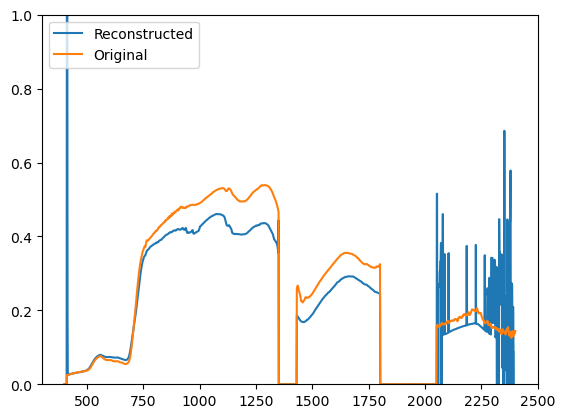

In [35]:
import random
# Get the number of rows
num_rows = data.shape[0]

# Sample an index value within the number of rows
index = random.randint(0, num_rows-1)
plt.plot(spectraindex, standardized_recon[index], label='Reconstructed')
plt.plot(spectraindex, standardized_data[index], label='Original')
plt.ylim(0, 1)
plt.legend(loc='upper left')  # Add a legend
plt.show()

## Load and apply new data
... to be prepared

In [36]:
#data_set2=DataBuilder(DATA_PATH)
#inferenceloader=DataLoader(dataset=data_set2,batch_size=1)

In [37]:
#with torch.no_grad():
#    for i, data in enumerate(inferenceloader):
#        data_inf = data.to(device)
#        recon_batch, mu, logvar = model(data_inf)

# what about the standardizer?

# Get Embeddings

In [38]:
mu_output = []
logvar_output = []

with torch.no_grad():
    for i, (data) in enumerate(trainloader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)

            
            mu_tensor = mu   
            mu_output.append(mu_tensor)
            mu_result = torch.cat(mu_output, dim=0)

            logvar_tensor = logvar   
            logvar_output.append(logvar_tensor)
            logvar_result = torch.cat(logvar_output, dim=0)

In [39]:
mu_result.shape

torch.Size([5883, 3])

In [40]:
# explore first rows of the embedding
mu_result[0:10,:]

tensor([[-2.0328e-01, -1.2074e+00, -3.6535e-03],
        [ 6.7945e-01, -6.9949e-02, -4.2333e-03],
        [ 1.0307e+00, -8.8456e-01, -5.8113e-03],
        [-1.2424e-01, -1.3457e+00, -4.1753e-03],
        [-4.4623e-01, -8.9050e-01, -4.1402e-03],
        [-3.7154e-01, -6.3141e-01, -3.4265e-03],
        [-2.2725e-01, -1.5412e-01, -4.2230e-03],
        [ 1.8069e+00, -2.6646e-01, -2.9229e-03],
        [ 1.4996e+00,  3.7576e-01, -1.1581e-03],
        [-3.5675e-01, -7.7016e-01, -3.7870e-03]], device='cuda:0')

In [41]:
numpy_array = mu_result.cpu().numpy()

In [70]:
# write emebddings to csv
#numpy_array = mu_result.numpy()

#np.savetxt(model_out_dir + 'embedding_train.csv', numpy_array, delimiter=',')

# write embeddings and traits to .csv
embeddings = pd.DataFrame(mu_result.cpu().numpy())
finalDf_vae = pd.concat([embeddings, pd.DataFrame(df_meta)], axis = 1)
finalDf_vae.to_csv(model_out_dir + 'embedding_vae.csv', index=False, header=True , sep=',')

In [72]:
finalDf_vae.head()

,0,1,2,Species,dataset,LandCover,Tool,Sensor,Site,Al_area_mg_cm2,...,Potassium_mass_mg_g,Protein_g_m2,RWC%,Starch_area_mg_cm2,Starch_mass_mg_g,Sugar_area_mg_cm2,Sugar_mass_mg_g,S_area_mg_cm2,S_mass_mg_g,Zn_mass_mg_g
0,-0.203284,-1.207357,-0.003654,Agrostis sp,1,Grassland,Proximal,ASD FieldSpec 3,"BattSP, Belgium",-99.0,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
1,0.679447,-0.069949,-0.004233,Agrostis sp,1,Grassland,Proximal,SVC HR-1024TM,"DeMatCem, Belgium",-99.0,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
2,1.030700,-0.884556,-0.005811,Agrostis sp,1,Grassland,Proximal,SVC HR-1024TM,"HaachtBev, Belgium",-99.0,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
3,-0.124243,-1.345706,-0.004175,Agrostis sp,1,Grassland,Proximal,ASD FieldSpec 3,"HaachtHol, Belgium",-99.0,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
4,-0.446227,-0.890503,-0.004140,Angelica sylvestris,1,Grassland,Proximal,SVC HR-1024TM,"HaachtBev, Belgium",-99.0,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0


# Basic plotting of the dimension reduction

## Plot Embeddings of PCA

In [73]:
from mpl_toolkits import mplot3d

# matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

### categorical variable

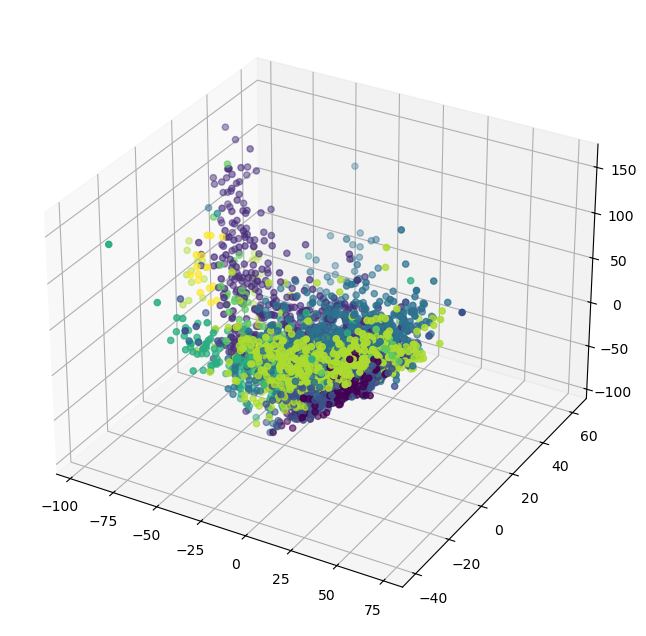

In [74]:
from sklearn.preprocessing import LabelEncoder

# Data for three-dimensional scattered points
metatype = finalDf['LandCover'].values.tolist()
# Create a label (category) encoder object
le = LabelEncoder()
# Fit and transform the classes to convert them into discrete integers
metatype_encoded = le.fit_transform(metatype)

fig = plt.figure(figsize=(10, 8))  # Adjust the width and height as needed
ax = fig.add_subplot(111, projection='3d')

zdata = finalDf.iloc[:,0].values
xdata = finalDf.iloc[:,1].values
ydata = finalDf.iloc[:,2].values
ax.scatter3D(xdata, ydata, zdata, c=metatype_encoded, cmap='viridis');


### continuous variable

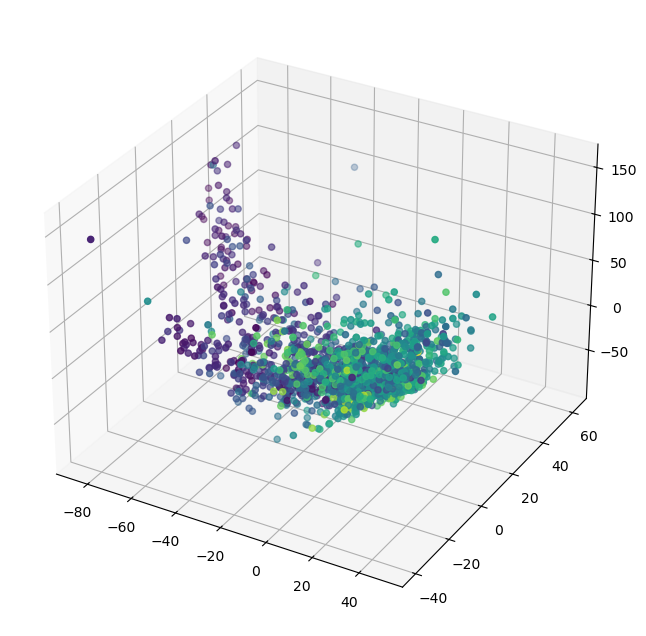

In [75]:
from sklearn.preprocessing import LabelEncoder

# Data for three-dimensional scattered points
variable = 'LAI_m2_m2'

filteredDf = finalDf[finalDf[variable] != -99]

metatype = filteredDf['LAI_m2_m2'].values

fig = plt.figure(figsize=(10, 8))  # Adjust the width and height as needed
ax = fig.add_subplot(111, projection='3d')

zdata = filteredDf.iloc[:,0].values
xdata = filteredDf.iloc[:,1].values
ydata = filteredDf.iloc[:,2].values
ax.scatter3D(xdata, ydata, zdata, c=metatype, cmap='viridis')
plt.show()


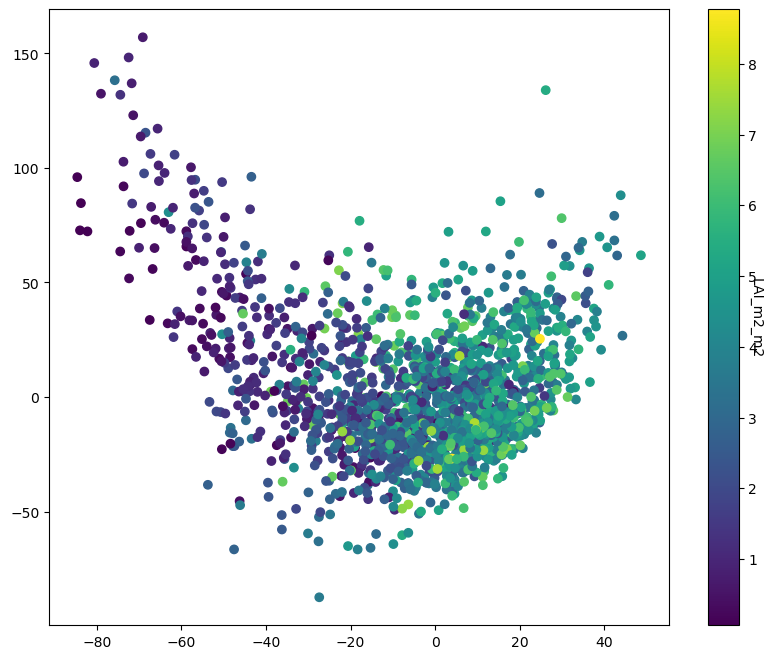

In [76]:
from sklearn.preprocessing import LabelEncoder

# Data for three-dimensional scattered points
variable = 'LAI_m2_m2'

filteredDf = finalDf[finalDf[variable] != -99]

metatype = filteredDf['LAI_m2_m2'].values

fig = plt.figure(figsize=(10, 8))  # Adjust the width and height as needed
ax = fig.add_subplot(111)

zdata = filteredDf.iloc[:,0].values
xdata = filteredDf.iloc[:,1].values
sc = ax.scatter(xdata, zdata, c=metatype, cmap='viridis')

cbar = plt.colorbar(sc)
cbar.set_label('LAI_m2_m2', rotation=270)

plt.show()


## Plot embeddings of autoencoder

### categorical variable

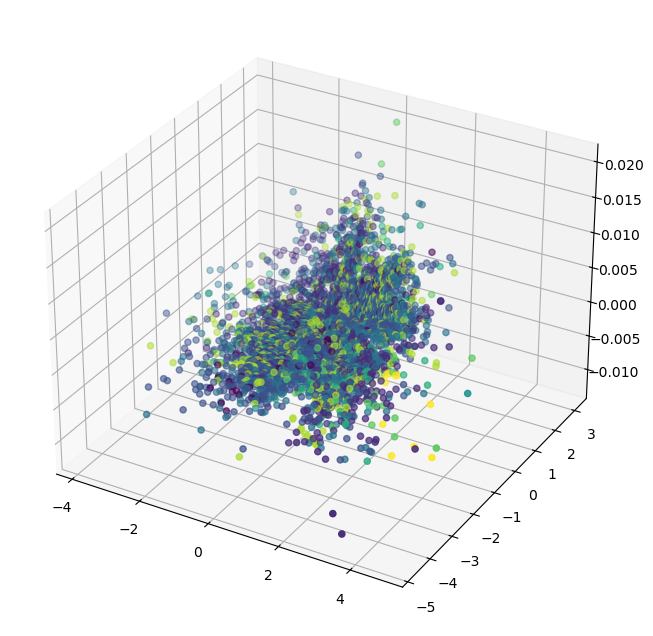

In [77]:
# Data for three-dimensional scattered points
# Data for three-dimensional scattered points
metatype = finalDf['LandCover'].values.tolist()
# Create a label (category) encoder object
le = LabelEncoder()
# Fit and transform the classes to convert them into discrete integers
metatype_encoded = le.fit_transform(metatype)

fig = plt.figure(figsize=(10, 8))  # Adjust the width and height as needed
ax = fig.add_subplot(111, projection='3d')

zdata = mu_result[:,2].cpu().numpy()
xdata = mu_result[:,0].cpu().numpy()
ydata = mu_result[:,1].cpu().numpy()
ax.scatter3D(xdata, ydata, zdata, c=metatype_encoded, cmap='viridis');

### continuous variable

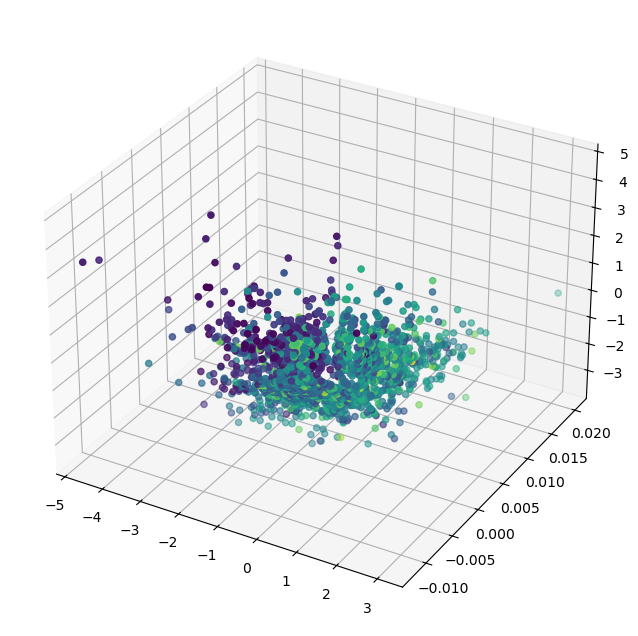

In [78]:
# Data for three-dimensional scattered points
# Data for three-dimensional scattered points

# Assuming finalDf is your DataFrame
#filteredDf = finalDf[(finalDf != -99).all(axis=1)]
#filteredmu_result = mu_result[(finalDf != -99).all(axis=1)]

variable = 'LAI_m2_m2'

filteredDf = finalDf[finalDf[variable] != -99]
filteredmu_result = mu_result[finalDf[variable] != -99]

metatype = filteredDf[variable].values

fig = plt.figure(figsize=(10, 8))  # Adjust the width and height as needed
ax = fig.add_subplot(111, projection='3d')

zdata = filteredmu_result[:,0].cpu().numpy()
xdata = filteredmu_result[:,1].cpu().numpy()
ydata = filteredmu_result[:,2].cpu().numpy()
ax.scatter3D(xdata, ydata, zdata, c=metatype, cmap='viridis');

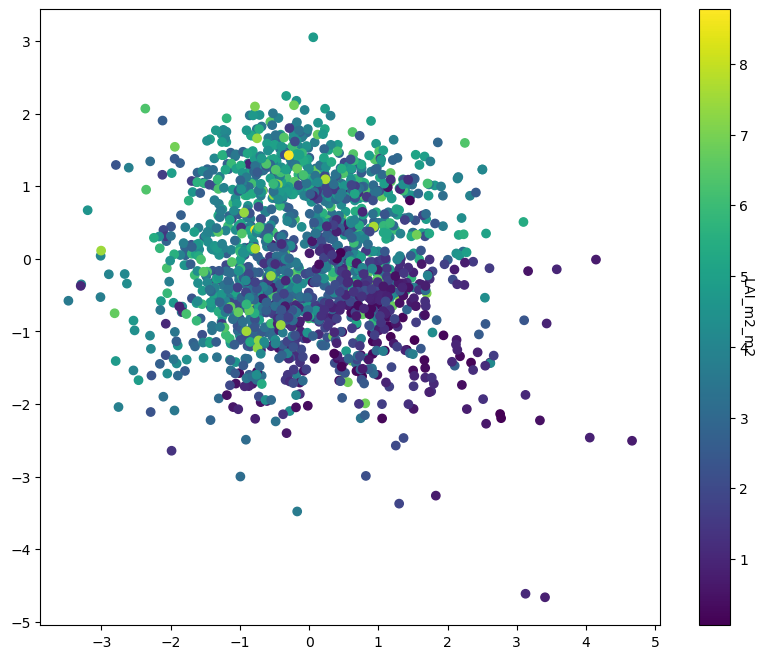

In [79]:
# Data for three-dimensional scattered points
# Data for three-dimensional scattered points

# Assuming finalDf is your DataFrame
#filteredDf = finalDf[(finalDf != -99).all(axis=1)]
#filteredmu_result = mu_result[(finalDf != -99).all(axis=1)]

variable = 'LAI_m2_m2'

filteredDf = finalDf[finalDf[variable] != -99]
filteredmu_result = mu_result[finalDf[variable] != -99]

metatype = filteredDf[variable].values

fig = plt.figure(figsize=(10, 8))  # Adjust the width and height as needed
ax = fig.add_subplot(111)

ydata = filteredmu_result[:,1].cpu().numpy()
xdata = filteredmu_result[:,0].cpu().numpy()
sc = ax.scatter(xdata, ydata, c=metatype, cmap='viridis');

cbar = plt.colorbar(sc)
cbar.set_label('LAI_m2_m2', rotation=270)

plt.show()

## trash bin

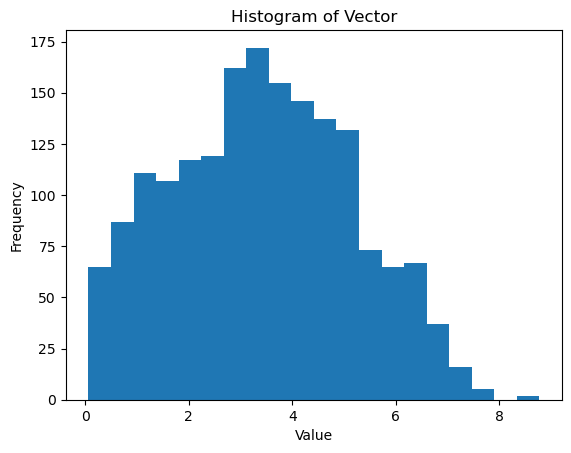

In [ ]:
plt.hist(metatype, bins='auto')  # 'auto' automatically determines the number of bins
plt.title('Histogram of Vector')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [ ]:

other_columns = ['other_col1', 'other_col2']

# Calculate correlations between other variables and principal components
correlations = pd.DataFrame(df_pca[:, :2], columns=['PC1', 'PC2']).apply(lambda x: df[other_columns].corrwith(x))

# Add the vectors for these variables
for i, column in enumerate(correlations.columns):
    plt.arrow(0, 0, correlations.loc['PC1', column], correlations.loc['PC2', column], color='b', alpha=0.5)
    plt.text(correlations.loc['PC1', column]*1.2, correlations.loc['PC2', column]*1.2, column, color='b', ha='center', va='center')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Biplot with additional variables')
plt.grid()
plt.show()